In [2]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-y_gu3c4n
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-y_gu3c4n
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=e1107d56ec38311979c107d83819f3d7c3789751a74dcc83aed0362e30beba4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9wtlknf/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [16]:
%%cuda --name matmul.cu
#include <cstdlib>
#include <curand.h>
#include <cublas_v2.h>
#include <iostream>
#include <ctime>

// Fill the array A(nr_rows_A, nr_cols_A) with random numbers on GPU
void GPU_fill_rand(double *A, int nr_rows_A, int nr_cols_A) {
    // Create a pseudo-random number generator
    curandGenerator_t prng;
    curandCreateGenerator(&prng, CURAND_RNG_PSEUDO_DEFAULT);
    // Set the seed for the random number generator using the system clock
    curandSetPseudoRandomGeneratorSeed(prng, (unsigned long long) clock());

    // Fill the array with random numbers on the device
    curandGenerateUniformDouble(prng, A, nr_rows_A * nr_cols_A);
}

// Multiply the arrays A and B on GPU and save the result in C
// C(m,n) = A(m,k) * B(k,n)
void gpu_blas_mmul(const double *A, const double *B, double *C, const int m, const int k, const int n) {
    int lda=m,ldb=k,ldc=m;
    const double alf = 1;
    const double bet = 0;
    const double *alpha = &alf;
    const double *beta = &bet;
    // Create a handle for CUBLAS
    cublasHandle_t handle;
    cublasCreate(&handle);
    // Do the actual multiplication
    // I switch the parameters A and B to be handled has column major
    cublasDgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, m, n, k, alpha, B, ldb, A, lda, beta, C, ldc);
    // Destroy the handle
    cublasDestroy(handle);
}

void cpu_mmul(const double *A, const double *B, double *C, const int N) {
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            C[i * N + j] = 0.0;
            for (int k = 0; k < N; ++k)
                C[i * N + j] += A[i * N + k] * B[k * N + j];
        }
    }
}

void print_matrix(double* matrix, int rows, int cols) {
	for(int i = 0; i < rows; ++i){
		for(int j = 0; j < cols; ++j){
			printf("%f ", matrix[i*rows + j]);
		}
		printf("\n");
	}
	printf("\n");
}

int main() {
    // Allocate 3 arrays on CPU
    int nr_rows_A, nr_cols_A, nr_rows_B, nr_cols_B, nr_rows_C, nr_cols_C, N;
    double start, end, gpu_time, cpu_time;

    // for simplicity we are going to use square arrays
    nr_rows_A = nr_cols_A = nr_rows_B = nr_cols_B = nr_rows_C = nr_cols_C = N = 100;
    double *h_A = (double *)malloc(nr_rows_A * nr_cols_A * sizeof(double));
    double *h_B = (double *)malloc(nr_rows_B * nr_cols_B * sizeof(double));
    double *h_C = (double *)malloc(nr_rows_C * nr_cols_C * sizeof(double));

    // Allocate 3 arrays on GPU
    double *d_A, *d_B, *d_C;
    cudaMalloc(&d_A,nr_rows_A * nr_cols_A * sizeof(double));
    cudaMalloc(&d_B,nr_rows_B * nr_cols_B * sizeof(double));
    cudaMalloc(&d_C,nr_rows_C * nr_cols_C * sizeof(double));

    // Fill the arrays A and B on GPU with random numbers
    GPU_fill_rand(d_A, nr_rows_A, nr_cols_A);
    GPU_fill_rand(d_B, nr_rows_B, nr_cols_B);

    // Optionally we can copy the data back on CPU and print the arrays
    cudaMemcpy(h_A,d_A,nr_rows_A * nr_cols_A * sizeof(double),cudaMemcpyDeviceToHost);
    cudaMemcpy(h_B,d_B,nr_rows_B * nr_cols_B * sizeof(double),cudaMemcpyDeviceToHost);
    std::cout << "A =" << std::endl;
    print_matrix(h_A, 5, 5);
    std::cout << "B =" << std::endl;
    print_matrix(h_B, 5, 5);

    // Multiply A and B on GPU
    start = clock();
    gpu_blas_mmul(d_A, d_B, d_C, nr_rows_A, nr_cols_A, nr_cols_B);
    end = clock();
    gpu_time = (end - start) / CLOCKS_PER_SEC;

    // Copy (and print) the result on host memory
    cudaMemcpy(h_C,d_C,nr_rows_C * nr_cols_C * sizeof(double),cudaMemcpyDeviceToHost);
    std::cout << "GPU C =" << std::endl;
    print_matrix(h_C, 5, 5);

    double *cpu_C = (double *)malloc(nr_rows_C * nr_cols_C * sizeof(double));
    start = clock();
    cpu_mmul(h_A, h_B, cpu_C, N);
    end = clock();
    cpu_time = (end - start) / CLOCKS_PER_SEC;
    std::cout << "CPU C =" << std::endl;
    print_matrix(cpu_C, 5, 5);

    double error = 0.0;
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            error += h_C[i * N + j] - cpu_C[i * N + j];
        }
    }

    std::cout << "\nError = " << error << std::endl;
    std::cout << "\nN = " << N << std::endl;
    std::cout << "\nGPU mul time = " << gpu_time << std::endl;
    std::cout << "\nCPU mul time = " << cpu_time << std::endl;

    //Free GPU memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    // Free CPU memory
    free(h_A);
    free(h_B);
    free(h_C);
    return 0;
}

'File written in /content/src/matmul.cu'

In [17]:
!nvcc -o /content/src/matmul /content/src/matmul.cu -lcurand -lcublas

In [18]:
!/content/src/matmul

A =
0.844492 0.911990 0.000489 0.550941 0.708054 
0.737119 0.926346 0.417379 0.163721 0.838779 
0.707753 0.836986 0.926417 0.735535 0.879712 
0.528414 0.388464 0.745783 0.009171 0.315684 
0.799919 0.353166 0.707929 0.459296 0.667571 

B =
0.955601 0.909119 0.527765 0.258019 0.951172 
0.648037 0.538285 0.261462 0.544558 0.225344 
0.443546 0.257550 0.488215 0.360512 0.115157 
0.559572 0.470428 0.630978 0.770834 0.355560 
0.215787 0.094661 0.636888 0.259618 0.155270 

GPU C =
25.151773 27.859753 25.129677 27.065901 24.232069 
27.325002 26.567360 24.880420 22.247559 21.556981 
26.906172 25.389642 27.555224 25.451055 26.100596 
28.090847 25.085958 25.693065 25.590741 26.458642 
25.344451 23.251650 27.100390 25.063112 24.833021 

CPU C =
25.151773 27.859753 25.129677 27.065901 24.232069 
27.325002 26.567360 24.880420 22.247559 21.556981 
26.906172 25.389642 27.555224 25.451055 26.100596 
28.090847 25.085958 25.693065 25.590741 26.458642 
25.344451 23.251650 27.100390 25.063112 24.833021 


E

In [20]:
!pip install matplotlib

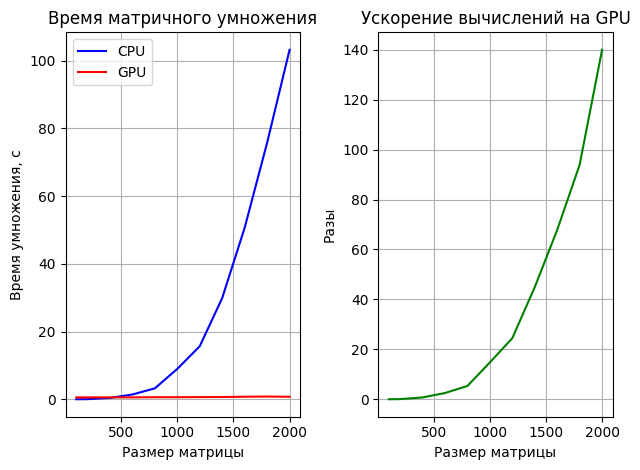

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
gpu_time = [0.549647, 0.552024, 0.558863, 0.56148, 0.60653, 0.60934, 0.64075, 0.66628, 0.74685, 0.80640, 0.73697]
cpu_time = [0.004294, 0.037585, 0.404768, 1.40593, 3.22605, 8.98707, 15.6758, 29.9115, 50.6523, 75.7411, 103.167]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Размер матрицы")
axes[0].set_ylabel("Время умножения, с")
axes[0].set_title('Время матричного умножения')

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Размер матрицы")
axes[1].set_ylabel("Разы")
axes[1].set_title('Ускорение вычислений на GPU')

plt.tight_layout()
plt.show()